In [ ]:
!pip install transformers[torch]==4.19.2 -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 59.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_score, accuracy_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from tqdm import tqdm, trange
import torch
import torch.nn as nn
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from time import time
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import random
plt.rcParams["figure.dpi"] = 80

TEMP = 0.75

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device available: ",device)
seed = 42
np.random.seed(seed)

Device available:  cuda


In [ ]:
# Input

# Trained Model
distilbert_model_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/model/distilbert_unprocessed_v1.pth'

# Input Data
data_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/data/Trademark_Decisions_Completed_Dataset_02.xlsx'

# Output Path
ttab_pred_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/data/TTAB_preds_complete_dataset.csv'

# DistilBERT Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [ ]:
# Function to generate batches and reshape
def batching(np_array, max_idx, batch_size):
    np_array = np_array[:max_idx]
    np_array = np_array.reshape(-1, batch_size)
    batched_list = np_array.tolist()
    return batched_list

In [ ]:
# Temperature Scaling
def T_scaling(logits, args):
    temperature = args.get('temperature', None)
    return torch.div(logits, temperature)

In [ ]:
# Function for predicting y
def bert_pred(model_path, X, y, tokenizer, th=0.5, temp=None):
    loaded_model = torch.load(model_path)
    predictions, targets = [], []
    pred_prob = []
    loaded_model.eval()
    with torch.no_grad():
        for text, labels in tqdm(zip(X, y), total=len(X)):
            #try:
            model_inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
            model_inputs = {k:v.to(device) for k,v in model_inputs.items()}
            output = loaded_model(**model_inputs)
            logits = output[0]
            if temp is not None:
                logits = T_scaling(logits, {'temperature':temp})
            probs = torch.sigmoid(logits)
            pred_prob.extend(probs[:,1].tolist())
            if th==0.5:
                # prediction is the argmax of the logits
                predictions.extend(logits.argmax(dim=1).tolist())
            else:
                predictions.extend(((probs[:,1]>=th)*1).tolist())
            targets.extend(labels)
            #except:
            #    print("Unable to process: ", text)
            #    continue
    return targets, pred_prob, predictions

### Process TTAB Data - What is product?

In [ ]:
xls = pd.ExcelFile(data_path)
df = pd.read_excel(xls, 'Marks')

In [ ]:
print(df.shape)
print(df.columns)

(527, 14)
Index(['Analyze', 'Case', 'Citation', 'Year', 'Mark', 'US Registration no.',
       'Serial no. (if not registered)', 'Nice class', 'Product',
       'Description', 'Comment from Coder', 'Classification by court',
       'Classificiation by court, binary (0=not distinctinve, 1= distinctive)',
       'Notes/Quotes from Decision'],
      dtype='object')


In [ ]:
df.head()

,Analyze,Case,Citation,Year,Mark,US Registration no.,Serial no. (if not registered),Nice class,Product,Description,Comment from Coder,Classification by court,"Classificiation by court, binary (0=not distinctinve, 1= distinctive)",Notes/Quotes from Decision
0,1,"Universal Church, Inc. v. Toellner",752 F. App'x 67 (2d Cir. 2018),2018,UNIVERSAL CHURCH,3037551.0,NaN,45,religious counseling and ministerial services,"evangelistic and ministerial services, namely,...",NaN,generic,0.0,"In this case, Universal Life Church met its bu..."
1,1,"ZW USA, Inc. v. PWD Sys., Ltd. Liab. Co.",889 F.3d 441 (8th Cir. 2018),2018,ONEPUL,4581881.0,NaN,6,plastic bags for picking up and disposing of d...,Fixed dispensers of metal for pet waste bags,NaN,"descriptive or generic, remanded",0.0,"In this case, PWD submitted evidence to show t..."
2,1,In re Magnesita Refractories Co.,716 F. App'x 978 (Fed. Cir. 2017),2017,MAGNESITA,NaN,85834316.0,19,refractory products,"refractory products not primarily of metal, na...",NaN,generic,0.0,The record before the Board includes numerous ...
3,1,"In re Cordua Rests., Inc.",823 F.3d 594 (Fed. Cir. 2016),2016,CHURRASCOS,3439321.0,NaN,43,steak restaurant,Restaurant *services excluding churrascaria re...,NaN,generic,0.0,There is substantial evidence in the record th...
4,1,"TRP Entm't, LLC v. Cunningham",637 F. App'x 334 (9th Cir. 2016),2016,THE RAT PACK IS BACK,2640066.0,NaN,41,Rat Pack tribute shows,"entertainment services, namely, live stage mus...","""THE RAT PACK"" is generic",generic,0.0,"Viewed in the light most favorable to TRP, the..."


In [ ]:
def convert_mark_types(x):
  x = str(x)
  if 'arbitrary' in x:
    return 'arbitrary'
  if 'fanciful' in x:
    return 'fanciful'
  if 'suggestive' in x or 'suggesitve' in x:
    return 'suggestive'
  if 'descriptive' in x:
    return 'descriptive'
  if 'generic' in x:
    return 'generic'
  else:
    print(x)
    return "none"

In [ ]:
df[['Mark','Classification by court']].groupby(by=['Classification by court']).count()

,Mark
Classification by court,
"""at best, descriptive""; no secondary meaning",2
"""at least suggestive""",2
arbitrary,44
arbitrary (-ish?),1
arbitrary or suggestive,1
arbitrary/fanciful,4
at least descriptive with secondary meaning,2
at least suggestive,5
descriptive,23


In [ ]:
df['mark_type'] = df['Classification by court'].apply(lambda x: convert_mark_types(x))
df[['Mark','mark_type']].groupby(by=['mark_type']).count()

nan


,Mark
mark_type,
arbitrary,80
descriptive,226
fanciful,46
generic,42
none,1
suggestive,132


In [ ]:
df.rename(columns={'Mark':'mark', 'Nice class':'nice_class', 'Description':'description',
                        'Classificiation by court, binary (0=not distinctinve, 1= distinctive)':'distinct_ind'},
          inplace=True)

cols_to_take = ['mark','description','nice_class','distinct_ind','mark_type']

df = df[cols_to_take].copy()
df = df.sample(frac=1, random_state=42)
df.reset_index(drop=True, inplace=True)
df.shape

(527, 5)

In [ ]:
df.isnull().sum()

mark            0
description     9
nice_class      0
distinct_ind    2
mark_type       0
dtype: int64

In [ ]:
# Drop Null values for now
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
print(df.shape)
df.isnull().sum()

(516, 5)


mark            0
description     0
nice_class      0
distinct_ind    0
mark_type       0
dtype: int64

In [ ]:
# Pre-process nice_class
df['nice_class'] = df['nice_class'].astype(int)
df['nice_class'] = df['nice_class'].apply(lambda x: "Nice class is " + str(x))
print(df.shape)
df.head()

(516, 5)


,mark,description,nice_class,distinct_ind,mark_type
0,BROWN-IN-BAG,TRANSPARENT PLASTIC FILM BAGS,Nice class is 16,1.0,suggestive
1,"""CASCADE"" DISTILLERY HAND MADE SOUR MASH GEO. ...",WHISKY,Nice class is 33,1.0,arbitrary
2,PRASTERONE.ORG\n,Providing a website featuring scientific and c...,Nice class is 42,0.0,generic
3,OGGETTI,[Desk pads; bookends; business card holders; p...,Nice class is 16,1.0,suggestive
4,RICE THINS,rice cakes,Nice class is 30,0.0,descriptive


In [ ]:
# Get Model Input
df['model_input'] = '[CLS] ' + df['mark'].astype(str) + ' [SEP] ' + df['description'].astype(str) + ' [SEP] ' + df['nice_class'].astype(str)
df['model_input'][50]

'[CLS] ONEPUL [SEP] Fixed dispensers of metal for pet waste bags [SEP] Nice class is 6'

### BERT Predictions

In [ ]:
# X_test
X_test = np.array(df['model_input'])
# y_test
y_test = np.array(df['distinct_ind'])


batch_size = df.shape[0]
# Batching
test_max_idx = batch_size * (len(X_test)//batch_size)
X_test = batching(X_test, test_max_idx, batch_size=batch_size)
y_test = batching(y_test, test_max_idx, batch_size=batch_size)

In [ ]:
# With temperature
labels, pred_prob_temp, predictions = bert_pred(distilbert_model_path, X_test, y_test, tokenizer, temp=TEMP)


100%|██████████| 1/1 [00:05<00:00,  5.14s/it]


In [ ]:
# Add probabilities to dataframe
df['model_probs'] = pred_prob_temp
df['model_preds'] = predictions
df.to_csv(ttab_pred_path, index=False)

### Get Performance Metrics

In [ ]:
df_out = pd.read_csv(ttab_pred_path)
df_out.head()

,mark,description,nice_class,distinct_ind,mark_type,model_input,model_probs,model_preds
0,BROWN-IN-BAG,TRANSPARENT PLASTIC FILM BAGS,Nice class is 16,1.0,suggestive,[CLS] BROWN-IN-BAG [SEP] TRANSPARENT PLASTIC F...,0.501376,0
1,"""CASCADE"" DISTILLERY HAND MADE SOUR MASH GEO. ...",WHISKY,Nice class is 33,1.0,arbitrary,"[CLS] ""CASCADE"" DISTILLERY HAND MADE SOUR MASH...",0.619997,1
2,PRASTERONE.ORG\n,Providing a website featuring scientific and c...,Nice class is 42,0.0,generic,[CLS] PRASTERONE.ORG\n [SEP] Providing a websi...,0.798523,1
3,OGGETTI,[Desk pads; bookends; business card holders; p...,Nice class is 16,1.0,suggestive,[CLS] OGGETTI [SEP] [Desk pads; bookends; busi...,0.896973,1
4,RICE THINS,rice cakes,Nice class is 30,0.0,descriptive,[CLS] RICE THINS [SEP] rice cakes [SEP] Nice c...,0.653136,1


### Overall Performance

In [ ]:
print("Incidence Rate: ", 100 * df_out['distinct_ind'].sum()/df_out.shape[0])

Incidence Rate:  50.3875968992248


In [ ]:
# Get true labels, predicted labels and probabilities associated
# Make Proline distinct_ind = 1
df_out['distinct_ind'][df_out['mark']=='PROLINE'] = 1
true_labels = df_out['distinct_ind'].tolist()
probs = df_out['model_probs']
pred_labels = df_out['model_preds'].tolist()


<ipython-input-25-b47c44d2563f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['distinct_ind'][df_out['mark']=='PROLINE'] = 1


<Axes: >

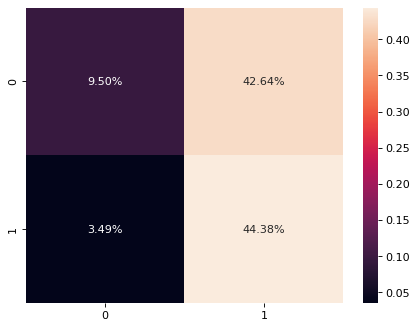

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Get the confusion matrix
cf_matrix = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')

In [ ]:
# Function to evaluate AUC ROC scores
def auc_roc(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return auc, fpr, tpr, optimal_threshold

auc, _ , _, opt_th = auc_roc(true_labels, probs)
print("AUC: ", auc)
print("Optimal Threshold: ", opt_th)

AUC:  0.5960447300693827
Optimal Threshold:  0.6921505331993103


In [ ]:
# Accuracy using 0.5 threshold
from sklearn.metrics import classification_report
from pprint import pprint
cls_report = classification_report(true_labels, pred_labels)
pprint(cls_report)

('              precision    recall  f1-score   support\n'
 '\n'
 '         0.0       0.73      0.18      0.29       269\n'
 '         1.0       0.51      0.93      0.66       247\n'
 '\n'
 '    accuracy                           0.54       516\n'
 '   macro avg       0.62      0.55      0.47       516\n'
 'weighted avg       0.63      0.54      0.47       516\n')


In [ ]:
# Accuracy using optimal threshold
true_labels = df_out['distinct_ind'].tolist()
probs = df_out['model_probs']
pred_labels = [1 if x>=opt_th else 0 for x in probs]
cls_report = classification_report(true_labels, pred_labels)
pprint(cls_report)

('              precision    recall  f1-score   support\n'
 '\n'
 '         0.0       0.65      0.43      0.52       269\n'
 '         1.0       0.55      0.74      0.63       247\n'
 '\n'
 '    accuracy                           0.58       516\n'
 '   macro avg       0.60      0.59      0.57       516\n'
 'weighted avg       0.60      0.58      0.57       516\n')


### Get metrics by mark_type

In [ ]:
probs_avg = df_out[['model_probs','mark_type']].groupby(by=['mark_type']).mean()
probs_std = df_out[['model_probs','mark_type']].groupby(by=['mark_type']).std()

print(probs_avg)
print(probs_std)

             model_probs
mark_type               
arbitrary       0.776735
descriptive     0.681341
fanciful        0.792613
generic         0.628756
suggestive      0.718265
             model_probs
mark_type               
arbitrary       0.114689
descriptive     0.203811
fanciful        0.096727
generic         0.208293
suggestive      0.184712


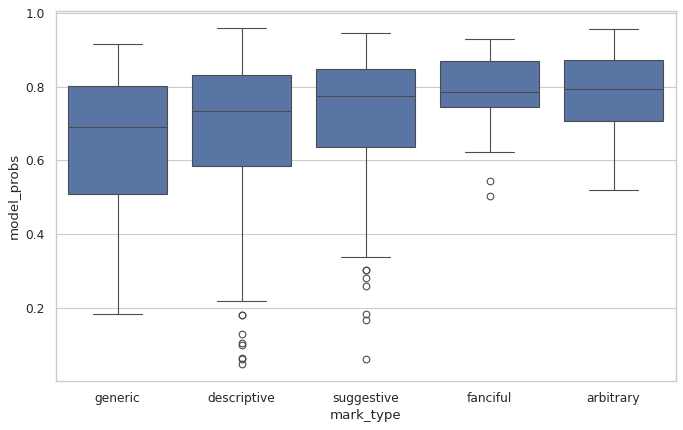

In [ ]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a point plot with confidence intervals
plt.figure(figsize=(10, 6))
sns.boxplot(x='mark_type', y='model_probs', data=df_out, order=['generic','descriptive','suggestive','fanciful','arbitrary'])

# Show the plot
plt.show()

In [ ]:
def performance_by_mark_type(df, mtype, th=0.5):
  df_mtype = df[df['mark_type']==mtype].copy()
  df_mtype.reset_index(drop=True, inplace=True)
  assert(len(df_out['distinct_ind'][df_out['mark_type']=='generic'].unique()) == 1)
  distinct_ind = df_mtype['distinct_ind'].unique()[0]

  probs = df_mtype['model_probs'].tolist()
  pred_labels = [0]*len(probs)
  for i in range(len(pred_labels)):
    if probs[i]>=th:
      pred_labels[i] = 1

  # Get correct predictions
  correct = 0
  for pred in pred_labels:
    if pred==distinct_ind:
      correct += 1

  perf = np.round(100*correct/len(pred_labels), 2)
  return perf
  # print("Correct Predictions for Mark Type {mtype} and threshold {th}: ".format(mtype=mtype, th=th), np.round(100*correct/len(pred_labels), 2))

In [ ]:
thlist = [x for x in np.arange(0,1,0.01)]
perf_generic = [performance_by_mark_type(df_out, 'generic', th) for th in thlist]
perf_descriptive = [performance_by_mark_type(df_out, 'descriptive', th) for th in thlist]
perf_arbitrary = [performance_by_mark_type(df_out, 'arbitrary', th) for th in thlist]
df_perf = pd.DataFrame({'threshold':thlist, 'generic':perf_generic, 'descriptive':perf_descriptive, 'arbitrary':perf_arbitrary})
df_perf.head()

,threshold,generic,descriptive,arbitrary
0,0.00,0.0,0.0,100.0
1,0.01,0.0,0.0,100.0
2,0.02,0.0,0.0,100.0
3,0.03,0.0,0.0,100.0
4,0.04,0.0,0.0,100.0


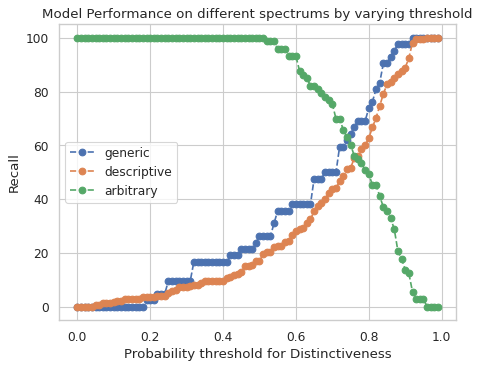

In [ ]:
plt.plot(thlist, perf_generic, '--o', label='generic')
plt.plot(thlist, perf_descriptive, '--o', label='descriptive')
plt.plot(thlist, perf_arbitrary, '--o', label='arbitrary')
plt.xlabel("Probability threshold for Distinctiveness")
plt.ylabel("Recall")
plt.title("Model Performance on different spectrums by varying threshold")
plt.legend()
plt.show()

In [ ]:
df_out[['model_preds','mark_type']].groupby(by=['mark_type']).count()

,model_preds
mark_type,
arbitrary,73
descriptive,225
fanciful,46
generic,42
suggestive,130


In [ ]:
import statistics
from math import sqrt

def plot_confidence_interval(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25):
    mean = statistics.mean(values)
    stdev = statistics.stdev(values)
    confidence_interval = z * stdev / sqrt(len(values))

    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='#f44336')

    return mean, confidence_interval

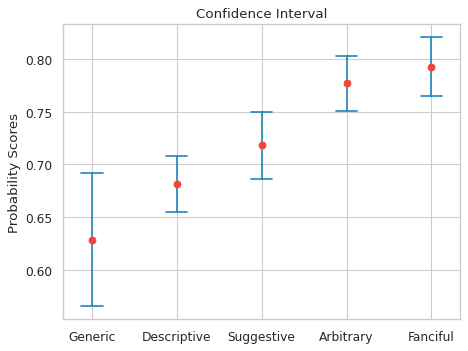

In [ ]:
plt.xticks([1, 2, 3, 4, 5], ['Generic', 'Descriptive', 'Suggestive', 'Arbitrary', 'Fanciful'])
plt.title('Confidence Interval')
plt.ylabel('Probability Scores')

preds_generic = df_out['model_probs'][df_out['mark_type']=='generic'].tolist()
preds_descriptive = df_out['model_probs'][df_out['mark_type']=='descriptive'].tolist()
preds_suggestive = df_out['model_probs'][df_out['mark_type']=='suggestive'].tolist()
preds_fanciful = df_out['model_probs'][df_out['mark_type']=='fanciful'].tolist()
preds_arbitrary = df_out['model_probs'][df_out['mark_type']=='arbitrary'].tolist()


plot_confidence_interval(1, preds_generic)
plot_confidence_interval(2, preds_descriptive)
plot_confidence_interval(3, preds_suggestive)
plot_confidence_interval(4, preds_arbitrary)
plot_confidence_interval(5, preds_fanciful)

plt.show()